### import the package

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**define the Class Camera**

Class Camera can be used to load the picture and cal_undistort

In [2]:
class Camera(object):
    """
    Camera is a class to define the camera
    """
    def __init__(self, nx, ny):
        """
        # initialize
        :param nx:
        :param ny:
        """
        self.nx = nx
        self.ny = ny
        self.objpoints = None
        self.imgpoints = None

    def _generate_array(self, length):
        """
        # generate imgpoints array
        # import by offical tutorial
        :param length:
        :return:
        """
        result = []
        objp = np.zeros((self.nx * self.ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)
        for i in range(length):
            result.append(objp)
        return result

    def load_picures(self, images):
        """
        # load picture to adjust the mtx and dist
        :param images:
        :return:
        """
        imgpoints = []
        for filename in images:
            # get an image
            img = mpimg.imread(filename)
            # transform to gray image
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # find the image color
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
            if ret:
                # calculate the mtx and dist
                imgpoints.append(corners)
        self.objpoints = self._generate_array(len(imgpoints))
        self.imgpoints = imgpoints

    def cal_undistort(self, img):
        """
        # input distort image
        # and calculate undistort image by mtx and dist
        :param img:  the output of cv2.imread
        :return:
        """
        if self.objpoints is None or self.imgpoints is None:
            raise Exception("this camera is not to adjust, so cannot use to cal_undistort image")
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            self.objpoints, self.imgpoints, gray.shape[::-1], None, None
        )
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img

In [3]:
def get_transform_m(src, dst):
    """
    # get the perspective transform function
    :param src:
    :param dst:
    :return:
    """
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


def perspective_transform(img, m):
    """
    # execute perspective transform
    :param img:
    :param m:
    :return:
    """
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    return warped


def reverse_picture(perspective_filter_img, left_fit, right_fit, Minv):
    """
    # 将转换图处理后的结果转换为正常视角
    :param perspective_filter_img:
    :param left_fit:
    :param right_fit:
    :param Minv:
    :return:
    """
    warp_zero = np.zeros_like(perspective_filter_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, perspective_filter_img.shape[0] - 1, perspective_filter_img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (perspective_filter_img.shape[1], perspective_filter_img.shape[0]))
    return newwarp

In [4]:
def color_thresholding_filter(img, min_thresholding, max_thresholding):
    """
    #
    :param img:
    :param min_thresholding:
    :param max_thresholding:
    :return:
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    result = np.zeros_like(s)
    result[(s >= min_thresholding) & (s <= max_thresholding)] = 1
    return result


def sobel_thresholding_filter(img, min_thresholding, max_thresholding, sobel_kernel):
    """
    #
    :param img:
    :param min_thresholding:
    :param max_thresholding:
    :return:
    """
    # convert color image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.power(np.power(sobelx, 2) + np.power(sobely, 2), 0.5)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # initial zeros array
    result = np.zeros_like(scaled_sobel)
    result[(scaled_sobel >= min_thresholding) & (scaled_sobel <= max_thresholding)] = 1
    return result


def gradient_thresholding_filter(img, min_thresholding, max_thresholding, sobel_kernel):
    """
    #
    :param img:
    :param min_thresholding:
    :param max_thresholding:
    :param sobel_kernel:
    :return:
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    gradient_sobel = np.arctan2(abs_sobely, abs_sobelx)
    result = np.zeros_like(gradient_sobel)
    result[(gradient_sobel >= min_thresholding) & (gradient_sobel <= max_thresholding)] = 1
    return result


def final_thresholding_filter(img, color_thresholding, gradient_thresholding, sobel_thresholding, sobel_kernal_size=3):
    """
    #
    :param img:
    :param color_thresholding:
    :param gradient_thresholding:
    :param sobel_thresholding:
    :param sobel_kernal_size:
    :return:
    """
    condition = (0 == 1)
    if color_thresholding:
        color_result = color_thresholding_filter(img, color_thresholding[0], color_thresholding[1])
        combined_result = np.zeros_like(color_result)
        condition = condition | (color_result == 1)
    if gradient_thresholding:
        gradient_result = gradient_thresholding_filter(img, gradient_thresholding[0], gradient_thresholding[1], sobel_kernal_size)
        combined_result = np.zeros_like(gradient_result)
        condition = condition | (gradient_result == 1)
    if sobel_thresholding:
        sobel_result = sobel_thresholding_filter(img, sobel_thresholding[0], sobel_thresholding[1], sobel_kernal_size)
        combined_result = np.zeros_like(sobel_result)
        condition = condition | (sobel_result == 1)

    try:
        combined_result[condition] = 1
    except Exception as e:
        raise Exception(str(e))
    return combined_result

In [5]:
def get_polynomial_fitting_curve(binary_warped):
    """
    # use histogram to localize the land line
    :param binary_warped: input is the filter_img after perspective transform
    # 输入图像是将阈值滤波的结果图像进行投影变换后的图像
    :return:
    """
    # 计算图像出现的直方图
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # 初始化一个输出图像，初始为输入图像的三次叠加且将1的点变为255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # 找出直方图的中位点，即图像的横中心
    midpoint = np.int(histogram.shape[0]//2)
    # 左侧车道认为是左侧直方图的最大值对应的点
    leftx_base = np.argmax(histogram[:midpoint])
    # 右侧的车道认为是右侧直方图最大值对应的点
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # 设置整幅图像滑窗的数目
    nwindows = 9
    # 计算每个滑窗的高度
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # 找出图像中所有点的坐标
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    # 设置初始窗的坐标点
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    # 设置窗的两侧宽度为100
    margin = 100

    # Set minimum number of pixels found to recenter window
    # 设置临近窗像素点的最小值为50
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    # 创建一个空数组用于接收左右车道的索引值
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    # 依次遍历每个窗口
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # 找出当前窗口对应的纵坐标的上限点和下限点
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # 分别找出左侧和右侧车道线的左边缘和右边缘
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # 在二维图像中划出该线段
        # 画出的是绿色的方框
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        # 找出在这个区域内的非零点
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        # 将这些非零点添加至数组中
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        # 当我们找到的点的数量大于我们设置的阈值时，下一个左侧车道和右侧车道的窗的中心位置分别对应于目前这个窗中的均值位置。
        # 从而实现更新了窗的中心位置
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # 将左、右侧的线段分别连接起来
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # 在图像中分别显示在左右区间内出现的阈值点
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Extract left and right line pixel positions
    # 抽取出左侧和右侧车道线的点位置
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # 对真实世界的尺度变换
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # 分别对左侧车道和右侧车道进行多项式拟合
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    # # 绘制左、右侧车道的拟合曲线
    # left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # plt.imshow(out_img)
    # # 画的是多项式拟合曲线
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)
    # plt.show()

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])

    car_center = (left_fit[0] * 720 ** 2 + left_fit[1] * 720 + left_fit[2] +
                  right_fit[0] * 720 ** 2 + right_fit[1] * 720 + right_fit[2]) / 2
    image_center = binary_warped.shape[1] / 2
    bias_meter = (car_center - image_center) * xm_per_pix
    return left_fit, right_fit, left_curverad, bias_meter

**draw the land line**

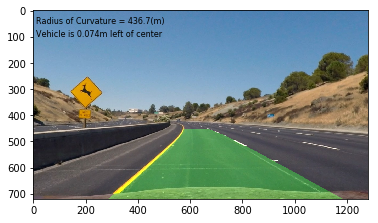

In [6]:
import os
camera = Camera(9, 6)
pictures_file_names = os.listdir("../camera_cal/")
pictures_list = ["../camera_cal/" + filename for filename in pictures_file_names]
camera.load_picures(pictures_list)
test_picture = "../test_images/test2.jpg"

img = mpimg.imread(test_picture)
undistort_img = camera.cal_undistort(img)
filter_result = final_thresholding_filter(undistort_img, [200, 255], [], [100, 255], sobel_kernal_size=3)
src = np.float32([[251.9, 688], [585.655, 455.895], [692.7, 455.895], [1054, 688]])
dst = np.float32([[300, 700], [300, 100], [900, 100], [900, 700]])

img_size = (img.shape[1], img.shape[0])
M, Minv = get_transform_m(src, dst)
perspective_filter_img = perspective_transform(filter_result, M)
# 得到的是将阈值图像透视变换后的二值图像

left_fit, right_fit, left_curverad, bias_meter = get_polynomial_fitting_curve(perspective_filter_img)
# left_curverad 曲率
# bias_meter中心偏移量

newwarp = reverse_picture(perspective_filter_img, left_fit, right_fit, Minv)
# Combine the result with the original image
result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
plt.imshow(result)
message_left_curverad = "Radius of Curvature = " + str(round(left_curverad, 1)) + "(m)"
if bias_meter < 0:
    message_bias_meter = "Vehicle is " + str(np.abs(round(bias_meter, 3))) + "m right of center"
else:
    message_bias_meter = "Vehicle is " + str(np.abs(round(bias_meter, 3))) + "m left of center"
plt.text(10, 50, message_left_curverad, fontsize=8)
plt.text(10, 100, message_bias_meter, fontsize=8)
plt.show()

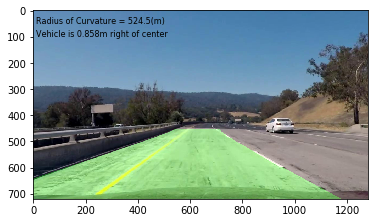

In [28]:
import os

# test_pictures_file_names = os.listdir("../test_images/")
test_pictures_file_names = ["basic1.jpg"]
for filename in test_pictures_file_names:
#     filename = "test2.jpg"
    test_picture = "../test_images/" + filename

    img = mpimg.imread(test_picture)
    undistort_img = camera.cal_undistort(img)

    filter_result = final_thresholding_filter(undistort_img, [200, 255], [], [100, 255], sobel_kernal_size=3)
    img_size = (img.shape[1], img.shape[0])
    M, Minv = get_transform_m(src, dst)
    perspective_filter_img = perspective_transform(filter_result, M)
    # 得到的是将阈值图像透视变换后的二值图像

    left_fit, right_fit, left_curverad, bias_meter = get_polynomial_fitting_curve(perspective_filter_img)
    # left_curverad 曲率
    # bias_meter中心偏移量

    newwarp = reverse_picture(perspective_filter_img, left_fit, right_fit, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    message_left_curverad = "Radius of Curvature = " + str(round(left_curverad, 1)) + "(m)"
    if bias_meter < 0:
        message_bias_meter = "Vehicle is " + str(np.abs(round(bias_meter, 3))) + "m right of center"
    else:
        message_bias_meter = "Vehicle is " + str(np.abs(round(bias_meter, 3))) + "m left of center"
    plt.text(10, 50, message_left_curverad, fontsize=8)
    plt.text(10, 100, message_bias_meter, fontsize=8)

    plt.savefig("../output_images/" + filename)

In [8]:
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from IPython.display import HTML

In [9]:
def process_image(image):
    try:
        undistort_img = camera.cal_undistort(image)
        filter_result = final_thresholding_filter(undistort_img, [200, 255], [], [100, 255], sobel_kernal_size=3)
        img_size = (image.shape[1], image.shape[0])
        M, Minv = get_transform_m(src, dst)
        perspective_filter_img = perspective_transform(filter_result, M)
        left_fit, right_fit, left_curverad, bias_meter = get_polynomial_fitting_curve(perspective_filter_img)
        newwarp = reverse_picture(perspective_filter_img, left_fit, right_fit, Minv)
        # Combine the result with the original image
        combine_image = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
        message_left_curverad = "Radius of Curvature = " + str(round(left_curverad, 1)) + "(m)"
        if bias_meter < 0:
            message_bias_meter = "Vehicle is " + str(np.abs(round(bias_meter, 3))) + "m right of center"
        else:
            message_bias_meter = "Vehicle is " + str(np.abs(round(bias_meter, 3))) + "m left of center"
        result1 = cv2.putText(combine_image,message_left_curverad,(0,40),cv2.FONT_HERSHEY_SIMPLEX,1.2,(255,255,255),2)
        result = cv2.putText(result1,message_bias_meter,(0,100),cv2.FONT_HERSHEY_SIMPLEX,1.2,(255,255,255),2)
    except Exception as e:
        result = image 
    return result

In [27]:
white_output = '../output_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/project_video_output.mp4
[MoviePy] Writing video ../output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [22:00<00:01,  1.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video_output.mp4 

Wall time: 22min 2s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
white_output = '../output_videos/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../challenge_video.mp4").subclip(0,1)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/challenge_video_output.mp4
[MoviePy] Writing video ../output_videos/challenge_video_output.mp4


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/challenge_video_output.mp4 

Wall time: 29.6 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
white_output = '../output_videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/harder_challenge_video.mp4
[MoviePy] Writing video ../output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [22:06<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/harder_challenge_video.mp4 

Wall time: 22min 9s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))